In [1]:
import nltk
import csv
import ssl ## workaround for my specific authorization issue
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from rake_nltk import Rake


from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn import svm

from gensim.models import Word2Vec
import time

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df =pd.read_csv("out_0426.csv")

In [3]:
df_balanced = pd.concat([df[df["stars"]==5].sample(5000), df[df["stars"]==4].sample(5000), \
                         df[df["stars"]==3].sample(10000), df[df["stars"]==2].sample(5000), \
                         df[df["stars"]==1].sample(5000)], axis=0)

#Larger df
sample_size = 10000
# df_balanced = pd.concat([complete_df[df["stars"]==5].sample(sample_size), complete_df[df["stars"]==4].sample(sample_size), \
#                          complete_df[df["stars"]==3].sample(sample_size*2), complete_df[df["stars"]==2].sample(sample_size), \
#                          complete_df[df["stars"]==1].sample(sample_size)], axis=0)
df_balanced.head(10)

,user_id,stars,useful,text,tokenized_text,tokenized_text_string,compound,neg,neu,pos,star_revised
150239,G-9QboxmMfNLafH_X_HZvQ,5,1,Really friendly and honest service and quality...,"['realli', 'friendli', 'honest', 'servic', 'qu...",realli friendli honest servic qualiti work wel...,0.9201,0.045,0.660,0.296,1
149511,XIWKPSY9T57bJbn2lEF3ow,5,2,I have to admit that I had reservations about ...,"['admit', 'reserv', 'bar', 'pool', 'concern', ...",admit reserv bar pool concern diminish realiz ...,0.6124,0.000,0.737,0.263,1
189527,1q_YMI8NQjq93JKJzFpMDg,5,0,Put this restaurant on the top of your list fo...,"['put', 'restaur', 'top', 'list', 'north', 'en...",put restaur top list north end extrem delici m...,0.4939,0.083,0.736,0.181,1
131081,E_bvTNcbGT1k8fJT9Vegzw,5,0,Love this place! Excellent service and ambienc...,"['love', 'place', 'excel', 'servic', 'ambienc'...",love place excel servic ambienc best massag ev...,0.9413,0.000,0.468,0.532,1
141609,5zeOnCBHToQRKvdzBDDlSQ,5,0,Found this place on yelp thought we would give...,"['found', 'place', 'yelp', 'thought', 'would',...",found place yelp thought would give shot every...,0.3612,0.000,0.839,0.161,1
137738,FsY4mm3lLWykDB_f1GQBwg,5,0,I'm a fashionista and have quite a wardrobe (o...,"[""'m"", 'fashionista', 'quit', 'wardrob', 'ok',...",'m fashionista quit wardrob ok three closet ta...,0.7906,0.000,0.778,0.222,1
198008,-XS0hiiOrWyH_MJDBsq41Q,5,0,My friend had a birthday party here on Septemb...,"['friend', 'birthday', 'parti', 'septemb', '17...",friend birthday parti septemb 17th staff amaz ...,0.9524,0.000,0.499,0.501,1
83769,Cc-RQbnVWO6EM0mLyIweEg,5,0,Came to check out one of the most famous brunc...,"['came', 'check', 'one', 'famou', 'brunch', 'p...",came check one famou brunch place area colleag...,0.9442,0.000,0.728,0.272,1
29279,Pqa1rGz_gXDCbPVwvxykjw,5,0,We went in for sake social hour without a rese...,"['went', 'sake', 'social', 'hour', 'without', ...",went sake social hour without reserv parti 9. ...,0.9118,0.000,0.682,0.318,1
785,gjqVMjWhRrH8FuYbJSwfmA,5,0,This is fantastic! We had cold lobster rolls a...,"['fantast', 'cold', 'lobster', 'roll', 'shrimp...",fantast cold lobster roll shrimp burger server...,0.6808,0.043,0.804,0.153,1


In [4]:
len(df_balanced)

30000

In [5]:
df = df_balanced.reset_index()
df.head()

,index,user_id,stars,useful,text,tokenized_text,tokenized_text_string,compound,neg,neu,pos,star_revised
0,150239,G-9QboxmMfNLafH_X_HZvQ,5,1,Really friendly and honest service and quality...,"['realli', 'friendli', 'honest', 'servic', 'qu...",realli friendli honest servic qualiti work wel...,0.9201,0.045,0.660,0.296,1
1,149511,XIWKPSY9T57bJbn2lEF3ow,5,2,I have to admit that I had reservations about ...,"['admit', 'reserv', 'bar', 'pool', 'concern', ...",admit reserv bar pool concern diminish realiz ...,0.6124,0.000,0.737,0.263,1
2,189527,1q_YMI8NQjq93JKJzFpMDg,5,0,Put this restaurant on the top of your list fo...,"['put', 'restaur', 'top', 'list', 'north', 'en...",put restaur top list north end extrem delici m...,0.4939,0.083,0.736,0.181,1
3,131081,E_bvTNcbGT1k8fJT9Vegzw,5,0,Love this place! Excellent service and ambienc...,"['love', 'place', 'excel', 'servic', 'ambienc'...",love place excel servic ambienc best massag ev...,0.9413,0.000,0.468,0.532,1
4,141609,5zeOnCBHToQRKvdzBDDlSQ,5,0,Found this place on yelp thought we would give...,"['found', 'place', 'yelp', 'thought', 'would',...",found place yelp thought would give shot every...,0.3612,0.000,0.839,0.161,1


In [6]:
len(df)

30000

## TF-IDF

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer
sentences = df["tokenized_text_string"]
# sentences = cleaned_df["text"]

vectorizer = TfidfVectorizer(norm = False, smooth_idf = False, min_df=0.005)
df["tfidf_vectors"] = vectorizer.fit_transform(sentences)
dd = vectorizer.fit_transform(sentences)
ddf =pd.DataFrame(dd.todense())
ddf

,0,1,2,3,4,5,6,7,8,9,...,1460,1461,1462,1463,1464,1465,1466,1467,1468,1469
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,4.580324,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## Hashing Vectorizer

In [110]:
from sklearn.feature_extraction.text import HashingVectorizer

sentences = df["tokenized_text_string"]

vectorizer = HashingVectorizer(norm = None, n_features = 1000)
df["hashing_vectors"] = vectorizer.fit_transform(sentences)

dd = vectorizer.fit_transform(sentences)
ddh =pd.DataFrame(dd.todense())
ddh

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Word2Vec

In [125]:
from gensim.models import Word2Vec
import time
# Skip-gram model (sg = 1)
# size = 1000
window = 3
min_count = 3
workers = 3
sg = 1

word2vec_model_file = 'word2vec_' + str(size) + '.model'
start_time = time.time()
stemmed_tokens = pd.Series(df['tokenized_text']).values
# Train the Word2Vec Model
# w2v_model = Word2Vec(stemmed_tokens, min_count = min_count, size = size, workers = workers, window = window, sg = sg)
w2v_model = Word2Vec(stemmed_tokens, min_count = 3, vector_size=1000)
print("Time taken to train word2vec model: " + str(time.time() - start_time))
w2v_model.save(word2vec_model_file)

Time taken to train word2vec model: 32.84359574317932


In [126]:
# Load the model from the model file
sg_w2v_model = Word2Vec.load(word2vec_model_file)
# Unique ID of the word
print("Index of the word 'food':")
print(sg_w2v_model.wv.key_to_index["a"])
# Total number of the words 
print(len(sg_w2v_model.wv))
# Print the size of the word2vec vector for one word
print("Length of the vector generated for a word")
print(len(sg_w2v_model.wv.get_vector("a", norm=True)))
# Get the mean for the vectors for an example review
print("Print the length after taking average of all word vectors in a sentence:")
# print(np.mean([sg_w2v_model[token] for token in df['tokenized_text'][0]], axis=0))
print(np.mean([sg_w2v_model.wv.get_vector(token, norm=True) for token in df['tokenized_text'][11243]], axis=0))

Index of the word 'food':
4
168
Length of the vector generated for a word
1000
Print the length after taking average of all word vectors in a sentence:
[ 4.77914177e-02 -2.53893454e-02 -1.35463029e-02  5.32147735e-02
 -8.55880510e-03 -7.63592916e-03  3.04604005e-02  1.05943186e-02
 -4.58948594e-03  8.54618102e-03 -1.96150541e-02  5.97004918e-03
  7.13171484e-03  1.64427254e-02  1.67092290e-02 -8.77008587e-03
 -4.20993827e-02 -5.53812347e-02  6.50733989e-03  8.04704428e-03
  1.26478123e-02  3.02573142e-04 -4.63775843e-02  3.89703587e-02
 -1.30587853e-02 -1.36456136e-02  5.09410761e-02 -5.09953536e-02
 -3.33961211e-02  9.79879219e-03  7.79924691e-02  2.10963488e-02
  1.34966020e-02  2.99918768e-03 -3.31212883e-03  8.06599855e-03
  1.26763079e-02  2.11314429e-02 -6.95192115e-03 -3.05405410e-04
 -2.01930720e-02 -3.73618677e-02 -7.02034906e-02  3.78745422e-02
 -4.78954576e-02 -2.95077283e-02 -6.30067242e-03  4.13317420e-02
 -3.92505340e-03 -8.90737341e-04  5.55181468e-04 -1.72849651e-02
  3

In [127]:
# def vecc(stem):
#     return np.mean([sg_w2v_model.wv.get_vector(token, norm=True) for token in stem], axis=0)
# ddw = df["tokenized_text"].apply(vecc)
def vecc(stem):
    stem_list = []
    for token in stem:
        if token not in sg_w2v_model.wv:
            continue
        else:
            stem_list.append(token)
    return np.mean([sg_w2v_model.wv.get_vector(token, norm=True) for token in stem_list], axis=0)

In [128]:
ddw = df["tokenized_text"].apply(vecc)
ddw.head()

0    [0.04423939, -0.025089698, -0.015006176, 0.050...
1    [0.0426616, -0.024300732, -0.014976867, 0.0484...
2    [0.045918547, -0.025017776, -0.01437428, 0.051...
3    [0.04766648, -0.022788648, -0.01194472, 0.0462...
4    [0.04316774, -0.02519928, -0.013906074, 0.0536...
Name: tokenized_text, dtype: object

In [129]:
ddw = ddw.tolist()

In [130]:
ddw = pd.DataFrame(ddw)
len(ddw)

30000

## Basic ML DF

In [141]:
ml = df[["text","stars","compound","neg","neu","pos","star_revised"]]
len(ml)

30000

In [142]:
ml.head()

,text,stars,compound,neg,neu,pos,star_revised
0,Really friendly and honest service and quality...,5,0.9201,0.045,0.660,0.296,1
1,I have to admit that I had reservations about ...,5,0.6124,0.000,0.737,0.263,1
2,Put this restaurant on the top of your list fo...,5,0.4939,0.083,0.736,0.181,1
3,Love this place! Excellent service and ambienc...,5,0.9413,0.000,0.468,0.532,1
4,Found this place on yelp thought we would give...,5,0.3612,0.000,0.839,0.161,1


## Complete DF

In [143]:
complete_df = pd.concat([ml, ddf, ddh, ddw], axis=1)
len(complete_df)

30000

In [144]:
complete_df.head(10)

,text,stars,compound,neg,neu,pos,star_revised,0,1,2,...,990,991,992,993,994,995,996,997,998,999
0,Really friendly and honest service and quality...,5,0.9201,0.045,0.660,0.296,1,0.0,0.0,0.0,...,0.036627,-0.019438,0.001469,0.021418,0.040891,0.016560,-0.018130,0.005157,-0.023405,-0.017994
1,I have to admit that I had reservations about ...,5,0.6124,0.000,0.737,0.263,1,0.0,0.0,0.0,...,0.037996,-0.016160,0.005254,0.025708,0.041000,0.020114,-0.019419,0.003843,-0.021275,-0.014785
2,Put this restaurant on the top of your list fo...,5,0.4939,0.083,0.736,0.181,1,0.0,0.0,0.0,...,0.036637,-0.017719,-0.001819,0.022197,0.040125,0.017015,-0.019663,0.005574,-0.019150,-0.017642
3,Love this place! Excellent service and ambienc...,5,0.9413,0.000,0.468,0.532,1,0.0,0.0,0.0,...,0.036225,-0.017077,0.003762,0.025469,0.040017,0.017514,-0.021493,0.002756,-0.027396,-0.015407
4,Found this place on yelp thought we would give...,5,0.3612,0.000,0.839,0.161,1,0.0,0.0,0.0,...,0.034032,-0.016568,-0.003202,0.019058,0.040529,0.015097,-0.018514,0.006709,-0.016303,-0.017254
5,I'm a fashionista and have quite a wardrobe (o...,5,0.7906,0.000,0.778,0.222,1,0.0,0.0,0.0,...,0.038534,-0.017201,0.001140,0.022438,0.040441,0.016561,-0.017883,0.002561,-0.023752,-0.016039
6,My friend had a birthday party here on Septemb...,5,0.9524,0.000,0.499,0.501,1,0.0,0.0,0.0,...,0.036170,-0.016116,-0.002077,0.021496,0.039279,0.016376,-0.017853,0.004326,-0.019120,-0.016249
7,Came to check out one of the most famous brunc...,5,0.9442,0.000,0.728,0.272,1,0.0,0.0,0.0,...,0.036003,-0.015878,-0.002203,0.021966,0.041750,0.016877,-0.024122,0.005083,-0.018470,-0.015612
8,We went in for sake social hour without a rese...,5,0.9118,0.000,0.682,0.318,1,0.0,0.0,0.0,...,0.037445,-0.016474,-0.001844,0.019111,0.038388,0.014544,-0.016057,0.004132,-0.018469,-0.016701
9,This is fantastic! We had cold lobster rolls a...,5,0.6808,0.043,0.804,0.153,1,0.0,0.0,0.0,...,0.037781,-0.016277,-0.002372,0.020410,0.041691,0.014672,-0.019065,0.003612,-0.018132,-0.014847


In [145]:
# complete_df = df_balanced
len(complete_df)

30000

In [146]:
# compression_opts = dict(method='zip', archive_name='out.csv')
# complete_df.to_csv('complete.zip', index=False, compression=compression_opts)

In [148]:
complete_df.iloc[:,7:]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.036627,-0.019438,0.001469,0.021418,0.040891,0.016560,-0.018130,0.005157,-0.023405,-0.017994
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.037996,-0.016160,0.005254,0.025708,0.041000,0.020114,-0.019419,0.003843,-0.021275,-0.014785
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.036637,-0.017719,-0.001819,0.022197,0.040125,0.017015,-0.019663,0.005574,-0.019150,-0.017642
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.036225,-0.017077,0.003762,0.025469,0.040017,0.017514,-0.021493,0.002756,-0.027396,-0.015407
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.034032,-0.016568,-0.003202,0.019058,0.040529,0.015097,-0.018514,0.006709,-0.016303,-0.017254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.036002,-0.016564,-0.002614,0.019775,0.039461,0.014942,-0.019962,0.004723,-0.019841,-0.016614
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.035718,-0.016143,-0.001573,0.021464,0.039454,0.016461,-0.021266,0.005889,-0.015884,-0.015449
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.036524,-0.017683,-0.003197,0.018658,0.036320,0.012450,-0.017898,0.005714,-0.016782,-0.015415
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.032326,-0.010404,0.000304,0.018111,0.039603,0.021161,-0.025898,0.005554,-0.015790,-0.016263


## 优先测试SVM

## Polarity_Score

In [184]:
X = complete_df[["compound","neg","neu","pos"]]
# X = X.head(10000)
y = complete_df["star_revised"]
# y = y.head(10000)

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [185]:
cc = complete_df[["text","star_revised","compound","neg","neu","pos"]]
cc

,text,star_revised,compound,neg,neu,pos
0,Really friendly and honest service and quality...,1,0.9201,0.045,0.660,0.296
1,I have to admit that I had reservations about ...,1,0.6124,0.000,0.737,0.263
2,Put this restaurant on the top of your list fo...,1,0.4939,0.083,0.736,0.181
3,Love this place! Excellent service and ambienc...,1,0.9413,0.000,0.468,0.532
4,Found this place on yelp thought we would give...,1,0.3612,0.000,0.839,0.161
...,...,...,...,...,...,...
29995,"""We are In-Network with many insurances and ha...",-1,0.7572,0.041,0.848,0.111
29996,The positive parts: Connie in financing is wo...,-1,0.9559,0.052,0.730,0.217
29997,Worst customer service I've ever had! The wait...,-1,-0.7964,0.321,0.679,0.000
29998,-1 \ncomplete scam. stay away. \nanyone want t...,-1,-0.5267,0.308,0.583,0.108


In [186]:
complete_df.iloc[20735,0]

"Nails are okay. Not very thorough, I wouldn't come back. And crew is not very friendly. I can see the difference between the first coat and second coat, which I'm not very fond of. The decorations are nice though."

In [42]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train_scaled, y_train)

y_pred = clf.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.5218518518518519
test accuracy: 0.519074074074074


In [43]:
y_test_pred = clf.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.529

In [187]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1068  486  254]
 [ 566  665  530]
 [ 368  584  879]]
Score: 48.37
Classification Report:               precision    recall  f1-score   support

          -1       0.53      0.59      0.56      1808
           0       0.38      0.38      0.38      1761
           1       0.53      0.48      0.50      1831

    accuracy                           0.48      5400
   macro avg       0.48      0.48      0.48      5400
weighted avg       0.48      0.48      0.48      5400



In [170]:
cc["predict"] = rmfr.predict(cc[["compound","neg","neu","pos"]])
cc

<ipython-input-170-b40eb4da9175>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cc["predict"] = rmfr.predict(cc[["compound","neg","neu","pos"]])


,text,star_revised,compound,neg,neu,pos,predict
0,Really friendly and honest service and quality...,1,0.9201,0.045,0.660,0.296,1
1,I have to admit that I had reservations about ...,1,0.6124,0.000,0.737,0.263,0
2,Put this restaurant on the top of your list fo...,1,0.4939,0.083,0.736,0.181,-1
3,Love this place! Excellent service and ambienc...,1,0.9413,0.000,0.468,0.532,1
4,Found this place on yelp thought we would give...,1,0.3612,0.000,0.839,0.161,0
...,...,...,...,...,...,...,...
29995,"""We are In-Network with many insurances and ha...",-1,0.7572,0.041,0.848,0.111,0
29996,The positive parts: Connie in financing is wo...,-1,0.9559,0.052,0.730,0.217,0
29997,Worst customer service I've ever had! The wait...,-1,-0.7964,0.321,0.679,0.000,-1
29998,-1 \ncomplete scam. stay away. \nanyone want t...,-1,-0.5267,0.308,0.583,0.108,-1


In [279]:
yy = pd.DataFrame(y_test)
yy["predict"] = predrmfr
yy[yy["predict"]!=yy["star_revised"]]

,star_revised,predict
4703,1,0
24008,-1,1
15095,0,-1
11376,0,1
7826,1,0
...,...,...
8698,1,0
20928,-1,0
10431,0,1
12668,0,1


In [237]:
cc.iloc[1861,0]

"Today we took the Granville Island Market foodie tour and we were so pleased.  The choices for tastings were delicious. The information and variety was thoughtful but we feel the reason the tour was a runaway success was our tour guide Jenny. Jenny found out about my gluten allergy minutes before we started. (Since that wasn't an accommodation for gluten mentioned online I was just planning to forgo the experiences which contained gluten) Jenny went above and beyond arranged for allowances and I only missed one tasting due to her efforts. She actually went out of her way to include everyone in the group. I would do it again. I would and have already suggested this tour to friends."

In [265]:
yy[yy.index==22109]

,star_revised
22109,-1


## 只有TF-IDF

In [366]:
X = complete_df.iloc[:,7:1469+7]
# X = X.sample(10000)
y = complete_df["star_revised"]
# y = y.sample(10000)

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [282]:
yyy = pd.DataFrame(y_test)


In [283]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1315  367  126]
 [ 385 1017  359]
 [ 154  406 1271]]
Score: 66.72
Classification Report:               precision    recall  f1-score   support

          -1       0.71      0.73      0.72      1808
           0       0.57      0.58      0.57      1761
           1       0.72      0.69      0.71      1831

    accuracy                           0.67      5400
   macro avg       0.67      0.67      0.67      5400
weighted avg       0.67      0.67      0.67      5400



In [284]:
yyy["pred"] = predrmfr
yyy[(yyy["pred"]!=yyy["star_revised"]) & (yyy["pred"]==0)].head(20)

,star_revised,pred
4703,1,0
6346,1,0
7826,1,0
6491,1,0
9922,1,0
20262,-1,0
22109,-1,0
24452,-1,0
4052,1,0
21271,-1,0


In [238]:
yyy[yyy.index==1861]

,star_revised,pred
1861,1,1


In [336]:
cc.iloc[9917,0]

"Great brunch place! Very different experience from other brunch places. It was on my restaurant bucket list during my trip to Vancouver. We heard of the big lines but when we came on an early Monday afternoon, the wait was only 10-15 minutes. Based on the Yelp reviews, I had high expectations. My expectations were met and everything was delicious but I still felt something was missing for me. I felt like a few of the dishes we tried were mains with an egg on top to call it brunch. Don't get me wrong, the food was amazing and delicious (hence my 4 stars), but I think it was overhyped a bit for me due to Yelp and others who recommended it to me. However majority do love this place and I can definitely see why. I absolutely LOVED the waffle. Get more than 1 if you're hungry! We tried the passionfruit topping which was so delicious and the rosewater white chocolate was just okay. \n\nI have to mention, their lattes are amazing! I had the Lavender Milk Chocolate Mocha and it did not disapp

In [330]:
yzyz = pd.merge(yy, yyy, how='inner', on=yyy.index)
yzyz = yzyz.drop("star_revised_y", axis = 1)
yzyz[(yzyz["predict"] != yzyz["pred"]) & (yzyz["predict"]==0) & (yzyz["star_revised_x"] == yzyz["pred"])].tail(20)
#predict: polarity; pred: TF-IDF

,key_0,star_revised_x,predict,pred
4545,23175,-1,0,-1
4600,23566,-1,0,-1
4610,20753,-1,0,-1
4611,20508,-1,0,-1
4718,20516,-1,0,-1
4732,7623,1,0,1
4824,4242,1,0,1
4836,23963,-1,0,-1
4856,5681,1,0,1
4878,20320,-1,0,-1


In [38]:
from sklearn import svm
clf2 = svm.SVC()
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf2.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.8063888888888889
test accuracy: 0.6468518518518519


In [41]:
y_test_pred = clf2.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.6453333333333333

In [368]:
from sklearn import svm
clf2 = svm.SVC()
clf2.fit(X_train_scaled, y_train)

y_pred = clf2.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf2.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.8762037037037037
test accuracy: 0.7083333333333334


## 只有 Hashing

In [369]:
X = complete_df.iloc[:,1469+7+1:1469+7+1+1000]
# X = X.sample(10000)
y = complete_df["star_revised"]
# y = y.sample(10000)

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [370]:
X

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
29997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1275  395  138]
 [ 415 1000  346]
 [ 194  437 1200]]
Score: 64.35
Classification Report:               precision    recall  f1-score   support

          -1       0.68      0.71      0.69      1808
           0       0.55      0.57      0.56      1761
           1       0.71      0.66      0.68      1831

    accuracy                           0.64      5400
   macro avg       0.65      0.64      0.64      5400
weighted avg       0.65      0.64      0.64      5400



In [88]:
from sklearn import svm
clf3 = svm.SVC()
clf3.fit(X_train_scaled, y_train)

y_pred = clf3.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf3.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.6432407407407408
test accuracy: 0.6316666666666667


In [89]:
y_test_pred = clf3.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.6313333333333333

In [371]:
from sklearn import svm
clf3 = svm.SVC()
clf3.fit(X_train_scaled, y_train)

y_pred = clf3.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = clf3.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.6450925925925926
test accuracy: 0.64


## 只有Word2Vec

In [138]:
X = complete_df.iloc[:,1469+7+1000+1+1:]
# X = X.sample(10000)
y = complete_df["star_revised"]
# y = y.sample(10000)

X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [139]:
X

,1,2,3,4,5,6,7,8,9,10,...,990,991,992,993,994,995,996,997,998,999
0,-0.025090,-0.015006,0.050183,-0.008713,-0.006472,0.029043,0.011336,-0.004276,0.009235,-0.018762,...,0.036627,-0.019438,0.001469,0.021418,0.040891,0.016560,-0.018130,0.005157,-0.023405,-0.017994
1,-0.024301,-0.014977,0.048436,-0.009314,-0.007004,0.030628,0.010205,-0.003486,0.007611,-0.018587,...,0.037996,-0.016160,0.005254,0.025708,0.041000,0.020114,-0.019419,0.003843,-0.021275,-0.014785
2,-0.025018,-0.014374,0.051697,-0.008166,-0.006112,0.029336,0.010121,-0.005199,0.008253,-0.017775,...,0.036637,-0.017719,-0.001819,0.022197,0.040125,0.017015,-0.019663,0.005574,-0.019150,-0.017642
3,-0.022789,-0.011945,0.046295,-0.008599,-0.007055,0.033095,0.012681,-0.009287,0.005893,-0.016834,...,0.036225,-0.017077,0.003762,0.025469,0.040017,0.017514,-0.021493,0.002756,-0.027396,-0.015407
4,-0.025199,-0.013906,0.053674,-0.007874,-0.006518,0.024930,0.009464,-0.001147,0.009133,-0.020017,...,0.034032,-0.016568,-0.003202,0.019058,0.040529,0.015097,-0.018514,0.006709,-0.016303,-0.017254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.023211,-0.013671,0.049007,-0.007228,-0.005886,0.028791,0.008451,-0.006890,0.006755,-0.017426,...,0.036002,-0.016564,-0.002614,0.019775,0.039461,0.014942,-0.019962,0.004723,-0.019841,-0.016614
29996,-0.023911,-0.013310,0.051653,-0.008006,-0.007004,0.028497,0.008945,-0.004729,0.008314,-0.018549,...,0.035718,-0.016143,-0.001573,0.021464,0.039454,0.016461,-0.021266,0.005889,-0.015884,-0.015449
29997,-0.023536,-0.017004,0.051705,-0.007962,-0.007366,0.028764,0.006435,-0.006404,0.007790,-0.019709,...,0.036524,-0.017683,-0.003197,0.018658,0.036320,0.012450,-0.017898,0.005714,-0.016782,-0.015415
29998,-0.022257,-0.009836,0.043181,-0.006999,-0.003796,0.031293,0.006433,-0.011897,0.005440,-0.014649,...,0.032326,-0.010404,0.000304,0.018111,0.039603,0.021161,-0.025898,0.005554,-0.015790,-0.016263


In [140]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[949 461 398]
 [525 686 550]
 [399 517 915]]
Score: 47.22
Classification Report:               precision    recall  f1-score   support

          -1       0.51      0.52      0.52      1808
           0       0.41      0.39      0.40      1761
           1       0.49      0.50      0.50      1831

    accuracy                           0.47      5400
   macro avg       0.47      0.47      0.47      5400
weighted avg       0.47      0.47      0.47      5400



In [53]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train_scaled,y_train)
predsvm = svm.predict(X_test_scaled)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[989 434 385]
 [570 658 533]
 [448 475 908]]
Score: 47.31
Classification Report:               precision    recall  f1-score   support

          -1       0.49      0.55      0.52      1808
           0       0.42      0.37      0.40      1761
           1       0.50      0.50      0.50      1831

    accuracy                           0.47      5400
   macro avg       0.47      0.47      0.47      5400
weighted avg       0.47      0.47      0.47      5400



In [94]:
y_pred = svm.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = svm.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.4764814814814815
test accuracy: 0.47314814814814815


In [95]:
y_test_pred = svm.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.4723333333333333

## All 

In [358]:
X = complete_df.drop(["stars","star_revised","text"], axis = 1)
X = X.iloc[:,0:2474]

y = complete_df["star_revised"]


X_train, X_final_test, y_train, y_final_test = train_test_split(X, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [359]:
X

,compound,neg,neu,pos,0,1,2,3,4,5,...,990,991,992,993,994,995,996,997,998,999
0,0.9201,0.045,0.660,0.296,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6124,0.000,0.737,0.263,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0
2,0.4939,0.083,0.736,0.181,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.9413,0.000,0.468,0.532,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3612,0.000,0.839,0.161,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0.7572,0.041,0.848,0.111,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29996,0.9559,0.052,0.730,0.217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0
29997,-0.7964,0.321,0.679,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29998,-0.5267,0.308,0.583,0.108,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


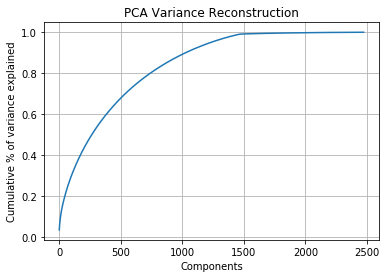

In [355]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. Normalize and center the x-vectors, the dataset is 
#    already in good shape so we will skip this part to
#    save ourselves some time/complications in the code.

# 2. Apply PCA
pca      = PCA()
X_pca    = pca.fit(X)

# 3. Visualize components' information value
plt.plot(np.cumsum(pca.explained_variance_ratio_));
plt.gca().set(
    title = "PCA Variance Reconstruction",
    xlabel = "Components",
    ylabel = "Cumulative % of variance explained"
);
plt.grid();

In [356]:
pca = PCA(n_components = 1500)
X_pca = pca.fit_transform(X)

X_train, X_final_test, y_train, y_final_test = train_test_split(X_pca, y, test_size=0.1, shuffle = True, random_state=123)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, shuffle = True, random_state=123)

scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[0.0355491 , 0.50024795, 0.45815863, ..., 0.48925193, 0.41129932,
        0.43080655],
       [0.08585552, 0.44845889, 0.47066507, ..., 0.48687777, 0.38738753,
        0.38001034],
       [0.02350612, 0.49280653, 0.44729831, ..., 0.48669687, 0.40545025,
        0.42267727],
       ...,
       [0.11655927, 0.50028818, 0.40146107, ..., 0.47143418, 0.39560665,
        0.42869813],
       [0.05525999, 0.50244182, 0.47263437, ..., 0.47651062, 0.41677048,
        0.42047238],
       [0.05128254, 0.49705442, 0.48513296, ..., 0.48629137, 0.39413511,
        0.41566367]])

In [357]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,3))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1251  399  158]
 [ 586  768  407]
 [ 330  474 1027]]
Score: 56.407
Classification Report:               precision    recall  f1-score   support

          -1       0.58      0.69      0.63      1808
           0       0.47      0.44      0.45      1761
           1       0.65      0.56      0.60      1831

    accuracy                           0.56      5400
   macro avg       0.56      0.56      0.56      5400
weighted avg       0.56      0.56      0.56      5400



## 分界线 向上看

In [104]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train_scaled,y_train)
predsvm = svm.predict(X_test_scaled)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[1237  416  155]
 [ 356  985  420]
 [ 154  324 1353]]
Score: 66.2
Classification Report:               precision    recall  f1-score   support

          -1       0.71      0.68      0.70      1808
           0       0.57      0.56      0.57      1761
           1       0.70      0.74      0.72      1831

    accuracy                           0.66      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.66      0.66      0.66      5400



In [105]:
y_pred = svm.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = svm.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.6712037037037037
test accuracy: 0.6620370370370371


In [106]:
y_test_pred = svm.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.6616666666666666

## 看SVM结果如何了

In [88]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier(max_depth=10)
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1246  360  202]
 [ 482  792  487]
 [ 239  376 1216]]
Score: 60.26
Classification Report:               precision    recall  f1-score   support

          -1       0.63      0.69      0.66      1808
           0       0.52      0.45      0.48      1761
           1       0.64      0.66      0.65      1831

    accuracy                           0.60      5400
   macro avg       0.60      0.60      0.60      5400
weighted avg       0.60      0.60      0.60      5400



## 测试最优tf-idf, hashing, 去掉w2v

In [360]:
# NEW ONE
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(X_train_scaled,y_train)
predrmfr = rmfr.predict(X_test_scaled)
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test,predrmfr))
print("Score:",round(accuracy_score(y_test,predrmfr)*100,3))
print("Classification Report:",classification_report(y_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1326  377  105]
 [ 387 1027  347]
 [ 151  418 1262]]
Score: 66.944
Classification Report:               precision    recall  f1-score   support

          -1       0.71      0.73      0.72      1808
           0       0.56      0.58      0.57      1761
           1       0.74      0.69      0.71      1831

    accuracy                           0.67      5400
   macro avg       0.67      0.67      0.67      5400
weighted avg       0.67      0.67      0.67      5400



In [362]:
# Support Vector Machine
from sklearn.svm import SVC
svm = SVC(random_state=101)
svm.fit(X_train_scaled,y_train)
predsvm = svm.predict(X_test_scaled)
print("Confusion Matrix for Support Vector Machines:")
print(confusion_matrix(y_test,predsvm))
print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
print("Classification Report:",classification_report(y_test,predsvm))

Confusion Matrix for Support Vector Machines:
[[1204  457  147]
 [ 333  991  437]
 [ 133  320 1378]]
Score: 66.17
Classification Report:               precision    recall  f1-score   support

          -1       0.72      0.67      0.69      1808
           0       0.56      0.56      0.56      1761
           1       0.70      0.75      0.73      1831

    accuracy                           0.66      5400
   macro avg       0.66      0.66      0.66      5400
weighted avg       0.66      0.66      0.66      5400



In [363]:
y_pred = svm.predict(X_test_scaled)
acc_test = (accuracy_score(y_pred,y_test))
y_pred = svm.predict(X_train_scaled)
acc_train = (accuracy_score(y_pred,y_train))
# print('kernel = rbf')
print('train accuracy: {}'.format(acc_train))
print('test accuracy: {}'.format(acc_test))

train accuracy: 0.667962962962963
test accuracy: 0.6616666666666666


In [364]:
y_test_pred = svm.predict(scaler.transform(X_final_test))
acc_test = (accuracy_score(y_test_pred,y_final_test))
acc_test

0.6696666666666666

In [365]:
(11/12+10/12+1+1+1+8/10)/6

0.9249999999999999